# Searching for QPPs with GPs for the ISSI Team

In [24]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit, minimize

import celerite
from celerite import terms
import emcee
import corner

from glob import glob
from astropy.io import fits

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
files = glob('../flares/*.fits')

In [4]:
def aflare1(t, tpeak, fwhm, ampl):
    '''
    The Analytic Flare Model evaluated for a single-peak (classical).
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723

    Use this function for fitting classical flares with most curve_fit
    tools.

    Note: this model assumes the flux before the flare is zero centered

    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    tpeak : float
        The time of the flare peak
    fwhm : float
        The "Full Width at Half Maximum", timescale of the flare
    ampl : float
        The amplitude of the flare

    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time
    '''
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]

    flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                (t > tpeak)],
                            [lambda x: (_fr[0]+                       # 0th order
                                        _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                        _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                        _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                        _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                             lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                        _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                            ) * np.abs(ampl) # amplitude

    return flare

In [5]:
# the basic liklihood fnction we'll need for the GP....
def neg_log_like(params, ynew, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(ynew)

In [237]:
def combined_model(params, x, y):
    flare_model = aflare1(x, params[0], params[1], params[2])
    decay = np.where((x >= params[0]) & (x <= params[0] + 5*params[1]))
    
    gp_model = np.zeros_like(flare_model)
    
    try:
        gp.set_parameter_vector(params[3:])
        # replace x[decay] with an up-smapled time vector if you want to draw finer GP model
        gp_model[decay] = gp.predict(y[decay] - flare_model[decay], x[decay], return_cov=False)
        return gp_model + flare_model
    
    except:
        raise ValueError('something something')
        return flare_model
    
  
    
def combined_log_prob(params, x, y, yerr):
    '''
    fit BOTH the flare + the QPP/GP
    params are: (tpeak, fwhm, ampl, SHO1,SHO2,SHO3)
    '''
    flare_model = aflare1(x, params[0], params[1], params[2])
    flare_lnlike = -0.5*(np.sum((y-flare_model)**2.0 / yerr**2.0)) # under-estimated probably...
    
    # establish flare decay portion to evaluate the GP
    decay = np.where((x >= params[0]) & (x <= params[0] + 5*params[1]))
    # need an error catch here if decay is empty...
    
    try: 
        gp.set_parameter_vector(params[3:])
        gp_lnlike = gp.log_likelihood(y[decay] - flare_model[decay])
    except:# (ValueError, LinAlgError):
        gp_lnlike = -np.inf

    lnout = flare_lnlike + gp_lnlike
    
    # add bounds
    if ((params[5] > 1) | (params[5] < -5)):
        lnout = -np.inf
    if params[2] < 0:
        lnout = -np.inf
    
    return lnout


0: Recovered Period = 7.0458468935515866 minutes


/Users/james/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/james/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


0: MCMC Period = 8.109269804397865 +/- 9.613973827278754


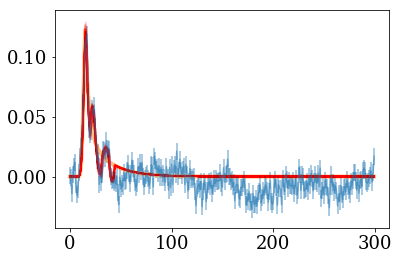

1: Suspect period =932.5073806654156


/Users/james/anaconda3/lib/python3.6/site-packages/celerite/terms.py:511: RuntimeWarning: overflow encountered in double_scalars
  f = np.sqrt(4.0 * Q**2-1)
/Users/james/anaconda3/lib/python3.6/site-packages/celerite/terms.py:500: RuntimeWarning: overflow encountered in double_scalars
  0.5*w0/Q*np.array([1.0-f, 1.0+f])
/Users/james/anaconda3/lib/python3.6/site-packages/celerite/terms.py:500: RuntimeWarning: invalid value encountered in multiply
  0.5*w0/Q*np.array([1.0-f, 1.0+f])
/Users/james/anaconda3/lib/python3.6/site-packages/celerite/terms.py:500: RuntimeWarning: divide by zero encountered in double_scalars
  0.5*w0/Q*np.array([1.0-f, 1.0+f])
/Users/james/anaconda3/lib/python3.6/site-packages/celerite/terms.py:514: RuntimeWarning: invalid value encountered in double_scalars
  S0 * w0 * Q / f,
/Users/james/anaconda3/lib/python3.6/site-packages/celerite/terms.py:516: RuntimeWarning: invalid value encountered in double_scalars
  0.5 * w0 / Q * f,
/Users/james/anaconda3/lib/python3.6

ValueError: something something

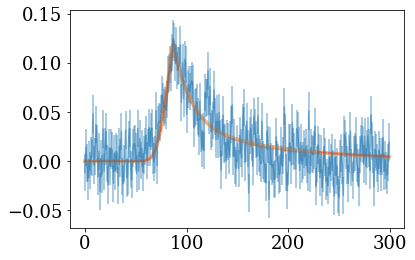

In [260]:
%%time

period_out = np.zeros(len(files))
period_err = np.zeros(len(files))
period_flag = np.zeros(len(files))
file_out = np.array(files, dtype=np.str)

for k in range(len(files)): 

    hdu = fits.open(files[k])
    data = hdu[1].data
    hdu.close()

    time = data.field(0)
    
    medflux = np.nanmedian(data.field(1))
    
    # detrend any underlying shape... (this is frought with danger)
    # we shall assume:
    # A) the flare is not in the first or last 10 data points
    # B) a linear polynomial is enough (for now)
    
    c1 = np.nanmedian(data.field(1)[0:10])
    c2 = np.nanmedian(data.field(1)[-10:])
    t1 = np.nanmedian(data.field(0)[0:10])
    t2 = np.nanmedian(data.field(0)[-10:])

    slope = (c2 - c1) / (t2 - t1)
    inter = c2 - slope*t2
    
    flux = (data.field(1) - (slope * time + inter)) / medflux
    
    # find the typical (median) scatter in small chunks of the light curve 
    # (11 data points, arbitrarily chosen) to use as the error
    std = np.nanmedian(pd.Series(flux).rolling(11).std())
    err = np.ones(time.size) * std
    
    
    # get approximate properties of flare
    ampl = np.nanmax(flux)
    f05 = np.where((flux >= ampl*0.5))
    fwhm = np.nanmax(time[f05]) - np.nanmin(time[f05])
    p0 = [time[np.argmax(flux)], fwhm, ampl]
    
    popt, pcov = curve_fit(aflare1, time, flux, p0=p0)
    
    
    # the decay region:
    # do from PEAK to 5X the FWHM timescale (i.e. don't fit the out-of-flare region)
    decay = np.where((time >= popt[0]) & (time <= popt[0] + 5*popt[1]))
    
    #__ do the GP __
    tresid = time[decay]
    eresid = err[decay]
    fresid = flux[decay] - aflare1(time[decay], *popt)

    # DO WE TRUST ALL THESE KERNEL PARAMETERS????
    # Celerite SHO Kernel:
    Q = 1.0
    w0 = 0.1
    S0 = np.std(fresid) #/ (w0 * Q)
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-5, 1))


    
    # draw the figure... put around the GP (annoyingly)
    plt.figure()
    plt.errorbar(time, flux, yerr=err, alpha=0.5)
    plt.plot(time, aflare1(time, *popt), alpha=0.5, lw=4)
    
    
    # wrap GP in Try/Except to catch some value error problem I don't understand
    try: 
        kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                                bounds=bounds)

        gp = celerite.GP(kernel, mean=np.mean(fresid))
        gp.compute(tresid, eresid)

        initial_params = gp.get_parameter_vector()
        bounds = gp.get_parameter_bounds()
        r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(fresid, gp))
        gp.set_parameter_vector(r.x)
        pred_mean, pred_var = gp.predict(fresid, tresid, return_var=True)
        pred_std = np.sqrt(pred_var)

    
        color = 'red'
        plt.plot(tresid, pred_mean + aflare1(tresid, *popt), color=color,label="GP") # GP fit
        plt.fill_between(tresid, pred_mean + pred_std + aflare1(tresid, *popt), 
                         pred_mean - pred_std + aflare1(tresid, *popt), 
                         color=color, alpha=0.3, edgecolor="none") # Standard deviation boundaries
        
        omega_0 = np.exp(gp.kernel.terms[0][2])
        period = (2*np.pi) / omega_0

        
        if (period < 200) & (period > 3):
            print(str(k) + ": Recovered Period = " + str(period) + " minutes")
            period_out[k] = period
            period_flag[k] = 0


        else:
            print(str(k) + ': Suspect period =' + str(period))
            period_out[k] = period
            period_flag[k] = 1

        
    except ValueError:
        print(str(k) + ': BAD/NO PERIOD (GP ERROR)')
        period_out[k] = -1
        period_flag[k] = 1



    plt.xlabel('Time')
    plt.ylabel('Relative Flux')
#     plt.title('Flare '+str(k)+' = ' + files[k][10:])
    plt.savefig('../figures/' + files[k][10:-5] + '-ls.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)
    plt.close()
    
    file_out[k] = files[k][10:-5]
    
    
    # now fit w/ MCMC together
    initial = np.array([*popt, *r.x])
    ndim, nwalkers = len(initial), 32
    sampler = emcee.EnsembleSampler(nwalkers, ndim, combined_log_prob, args=[time, flux, err])

    p0mcmc = initial + 1e-1*np.random.randn(nwalkers, ndim)
    p0mcmc, ln, _ = sampler.run_mcmc(p0mcmc, 1000) #  burn-in
    sampler.reset()
    _ = sampler.run_mcmc(p0mcmc, 5000) #  MCMC run

    samples = sampler.flatchain
    med = np.nanmedian(samples, axis=0)
    # mstd = np.nanstd(samples, axis=0)
    mstd = np.sqrt(np.sum(np.abs(np.percentile(samples, [16, 84], axis=0) - med)**2, axis=0))

    
    plt.figure()
    plt.errorbar(time, flux, yerr=err, alpha=0.5)
    plt.plot(time, aflare1(time, *popt), alpha=0.5, lw=4)

    for l in range(200):
        xp = samples[np.random.randint(len(samples))]
        plt.plot(time, combined_model(xp, time ,flux), color="r", alpha=0.02)


    period_out[k] = ((2*np.pi) / np.exp(med[5]))
    period_err[k] = (np.abs((2*np.pi) / np.exp(-1 * mstd[5])))
    print(str(k) + ": MCMC Period = " + str(period_out[k]) + ' +/- '+str(period_err[k]))
    
    plt.savefig('../figures/' + files[k][10:-5] + '-mc.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)
    if k < 15:
        plt.show()
    else:
        plt.close()



    
    # To do inside loop (for each flare):
    # 1x) find flare peak
    # 2x) fit Davenport'14 flare model
    # 3x) fit GP on decay phase (residual)
    # 4) TRY: fit flare model + GP simultaneously w/ MCMC
    # 5x) make plot(s), produce table(s)



In [261]:
dfout = pd.DataFrame(data={'file':file_out, 'period':period_out, 'flag':period_flag, 'per_err':period_err})

In [262]:
dfout.to_csv('GP_output_v0.2.csv')

In [ ]:
# get MCMC working on 1 flare...

23.70557121653785


Text(0, 0.5, 'Relative Flux')

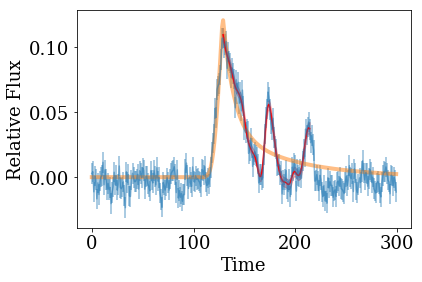

In [255]:
k=93

hdu = fits.open(files[k])
data = hdu[1].data
hdu.close()

time = data.field(0)

medflux = np.nanmedian(data.field(1))

# detrend any underlying shape... (this is frought with danger)
# we shall assume:
# A) the flare is not in the first or last 10 data points
# B) a linear polynomial is enough (for now)

c1 = np.nanmedian(data.field(1)[0:10])
c2 = np.nanmedian(data.field(1)[-10:])
t1 = np.nanmedian(data.field(0)[0:10])
t2 = np.nanmedian(data.field(0)[-10:])

slope = (c2 - c1) / (t2 - t1)
inter = c2 - slope*t2

flux = (data.field(1) - (slope * time + inter)) / medflux
flux = flux - np.nanmedian(flux)

# find the typical (median) scatter in small chunks of the light curve 
# (11 data points, arbitrarily chosen) to use as the error
std = np.nanmedian(pd.Series(flux).rolling(11).std())
err = np.ones(time.size) * std


# get approximate properties of flare
ampl = np.nanmax(flux)
f05 = np.where((flux >= ampl*0.5))
fwhm = np.nanmax(time[f05]) - np.nanmin(time[f05])
p0 = [time[np.argmax(flux)], fwhm, ampl]

popt, pcov = curve_fit(aflare1, time, flux, p0=p0)


# the decay region:
# do from PEAK to 5X the FWHM timescale (i.e. don't fit the out-of-flare region)
decay = np.where((time >= popt[0]) & (time <= popt[0] + 5*popt[1]))

#__ do the GP __
tresid = time[decay]
eresid = err[decay]
fresid = flux[decay] - aflare1(time[decay], *popt)

# DO WE TRUST ALL THESE KERNEL PARAMETERS????
# Celerite SHO Kernel:
Q = 1.0
w0 = 0.1
S0 = np.std(fresid) #/ (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-5, 1))


# draw the figure... put around the GP (annoyingly)
plt.figure()
plt.errorbar(time, flux, yerr=err, alpha=0.5)
plt.plot(time, aflare1(time, *popt), alpha=0.5, lw=4)


# wrap GP in Try/Except to catch some value error problem I don't understand
# try: 
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

gp = celerite.GP(kernel, mean=np.mean(fresid))
gp.compute(tresid, eresid)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(fresid, gp))
gp.set_parameter_vector(r.x)
pred_mean, pred_var = gp.predict(fresid, tresid, return_var=True)
pred_std = np.sqrt(pred_var)


color = 'red'
plt.plot(tresid, pred_mean + aflare1(tresid, *popt), color=color,label="GP") # GP fit
plt.fill_between(tresid, pred_mean + pred_std + aflare1(tresid, *popt), 
                 pred_mean - pred_std + aflare1(tresid, *popt), 
                 color=color, alpha=0.3, edgecolor="none") # Standard deviation boundaries

omega_0 = np.exp(gp.kernel.terms[0][2])
period = (2*np.pi) / omega_0

print(period)
    
# except:
#     print('nope')
    
plt.xlabel('Time')
plt.ylabel('Relative Flux')



In [256]:

# now fit w/ MCMC together
initial = np.array([*popt, *r.x])
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, combined_log_prob, args=[time, flux, err])
    
p0mcmc = initial + 1e-1*np.random.randn(nwalkers, ndim)
p0mcmc, ln, _ = sampler.run_mcmc(p0mcmc, 1000) #  burn-in
sampler.reset()
_ = sampler.run_mcmc(p0mcmc, 5000) #  MCMC run
    
samples = sampler.flatchain
med = np.nanmedian(samples, axis=0)
# mstd = np.nanstd(samples, axis=0)
mstd = np.sqrt(np.sum(np.abs(np.percentile(samples, [16, 84], axis=0) - med)**2, axis=0))



In [257]:

print(med)
print(mstd)

print((2*np.pi) / np.exp(med[5]))
print(np.abs((2*np.pi) / np.exp(-1 * mstd[5])))

[ 1.28647856e+02  1.71771953e+01  1.24839881e-01 -7.16392853e+00
  4.58723054e-01 -1.36360603e+00]
[0.26802212 0.10247794 0.00316501 1.06856579 1.0613173  0.24345977]
24.568941253221755
8.015176701052063


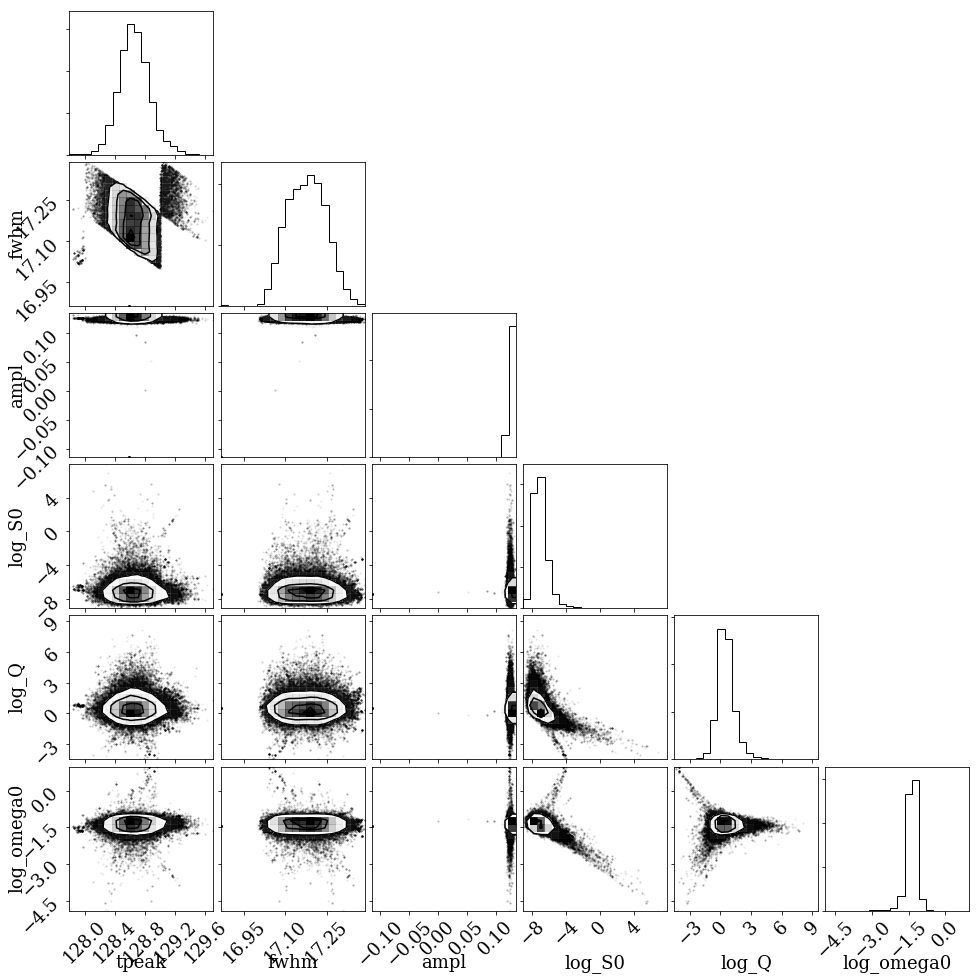

In [258]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=['tpeak', 'fwhm', 'ampl', 'log_S0','log_Q','log_omega0'])

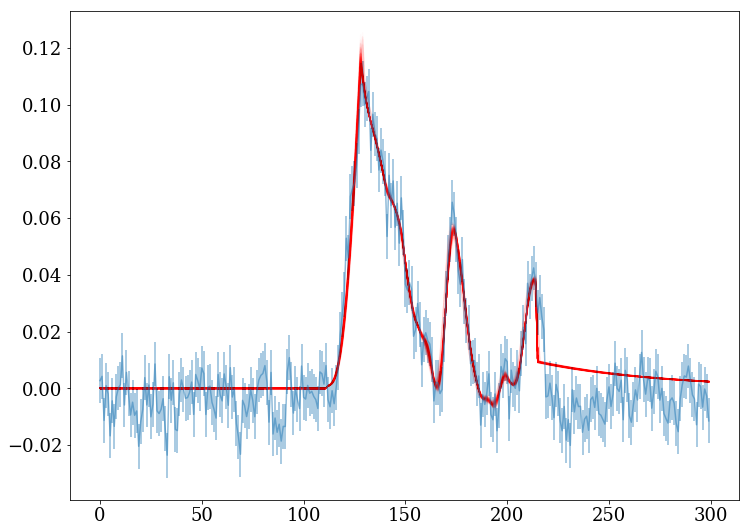

In [259]:
plt.figure(figsize=(12,9))
plt.errorbar(time, flux, yerr=err, alpha=0.5)

for l in range(200):
    xp = samples[np.random.randint(len(samples))]
    plt.plot(time, combined_model(xp, time ,flux), color="r", alpha=0.02)

# plt.plot(time, combined_model(med, time ,flux), color="k", alpha=0.6)
# plt.xlim(100,250)